In [3]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(10, 8)) # Larger figure sizes

### Exercise 1: Anatomy of a sunspot

There is only one exercise in this project. You should answer the question points not in order but in a coherent essay, having a narrative interspersed with code when necessary. This is a project of exploration. You will need to explore the data on your own, using the concepts, knowledge, and terminology you have acquired so far in AST4310. This will involve experimenting on how to best measure properties from spectra, how to visualise them, and discussing their physical meaning.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
Imagine you are one of the pioneers observing sunspots for the first time and know nothing about their properties. Your task is to analyse the SST dataset using the spectral diagnostics listed above. In your essay, you should report your findings to an audience of your peers who are similarly ignorant about sunspots, but knowledgeable about spectral analysis (so you don't need to explain what spectral lines are or what we can learn from them). You should answer the following questions:
    
- Using spectral velocities and brightness temperatures, what can you tell about the dynamics of the solar granulation? Which is cooler: the granules or the inter-granular lanes? How are they moving in relation to us?
- In terms of spectral properties, what sets a sunspot apart from the neigbouring granulation?
- Do pores share the same spectral properties of sunspots? Are the two connected?
- Where in a sunspot do you find the largest velocities? And the strongest magnetic fields?
- How much colder are sunspots than the solar granulation? Why are they dark?
- How does the size of this sunspot compare with planet Earth?
    
</div>

In [5]:
data = QTable.read('SST_sunspot_617_2020.08.07.fits')
data

"intensity [961,974]","stokes_v [961,974]",wavelength
W / (Hz m2 sr),W / (Hz m2 sr),nm
float32,float32,float64
3.81328142395887e-08 .. 3.623370403715853e-08,-3.2918050230090756e-11 .. 1.8876449014992858e-10,617.268
3.768163381323575e-08 .. 3.59759475543342e-08,-1.327763853725683e-11 .. -3.162058948014135e-10,617.276
3.667330616963227e-08 .. 3.392468883589572e-08,-7.741495638979856e-11 .. -9.938728312564038e-11,617.284
3.548280247400726e-08 .. 2.985078495498783e-08,-8.753564539887293e-11 .. -3.744499710300886e-10,617.288
3.0823972707594294e-08 .. 2.4031239220789757e-08,-1.4693181393798938e-10 .. -5.6474065007749985e-11,617.292
2.3560883022355483e-08 .. 2.1409466199884264e-08,-6.235768845730405e-12 .. -3.969632348527208e-12,617.296
2.199313975381756e-08 .. 2.410669708297064e-08,-8.666208722862834e-11 .. -3.1688598967072323e-10,617.3
2.8138451568793243e-08 .. 2.8830916320998767e-08,-1.517680286999834e-10 .. -3.0086358404624036e-10,617.304


In [6]:
data["wavelength"][0]

<Quantity 617.268 nm>

<div>

- mu = v_los / v = sum(lambda * I_lambda * dlambda) / sum(I_lambda * dlambda)
- sigma_2 = sum((lambda - mu) ** 2 * I_lambda * dlambda) / sum(I_lambda * dlambda)
- Width = 2 * sqrt(2 * ln(2) * sigma_2)    

</div>

In [7]:
import scipy.integrate as integ
print()
integral_1 = np.zeros(data["intensity"][0].shape)
integral_2 = np.zeros(data["intensity"][0].shape)
intensity = np.zeros(data["intensity"].shape)

for i in range(len(data["intensity"])):
    intensity[i] = data["intensity"][0].value - data["intensity"][i].value

for i in range(len(data["intensity"][0])):
    for j in range(len(data["intensity"][0][0])):
        integral_1[i, j] = integ.trapz(data["wavelength"].value * intensity[:, i, j], data["wavelength"].value)
        integral_2[i, j] = integ.trapz(intensity[:, i, j], data["wavelength"].value)
mu = integral_1 / integral_2

np.save("mu.npy", mu)

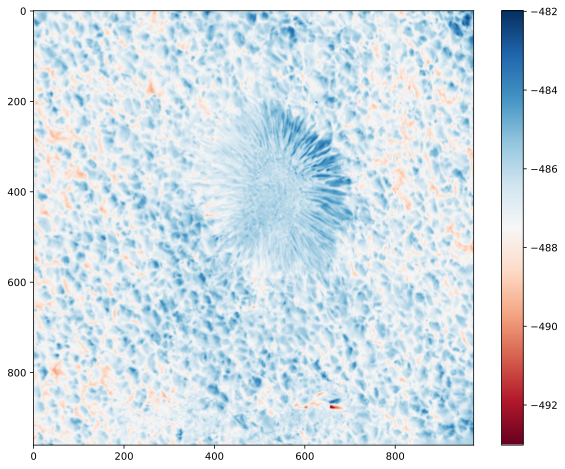

In [8]:
mu = np.load("mu.npy") * units.nm

lam_0 = 616.300 * units.nm

v = constants.c * (lam_0 - mu) / lam_0

fig, ax = plt.subplots(figsize=(10,8))
p = ax.imshow(v.to("km/s"), cmap='RdBu');
fig.colorbar(p, ax = ax)

In [15]:
g = 2.499

dI_dl = np.zeros(data["intensity"].shape)
for i in range(len(data["intensity"][0])):
    for j in range(len(data["intensity"][0][0])):
        dI_dl[:, i, j] = np.gradient(intensity[:, i, j], data["wavelength"].value)

#for i in range(data["wavelength"]):
#    sum_1 = sum_1 + dI_dl * data["stokes_v"][i]

B = - 4 * np.pi * constants.m_e * constants.c / constants.e.si * g * lam_0 ** 2 * np.sum(dI_dl * data["stokes_v"], axis = 0) / np.sum(dI_dl ** 2, axis = 0)

np.save("B.npy", B.value)

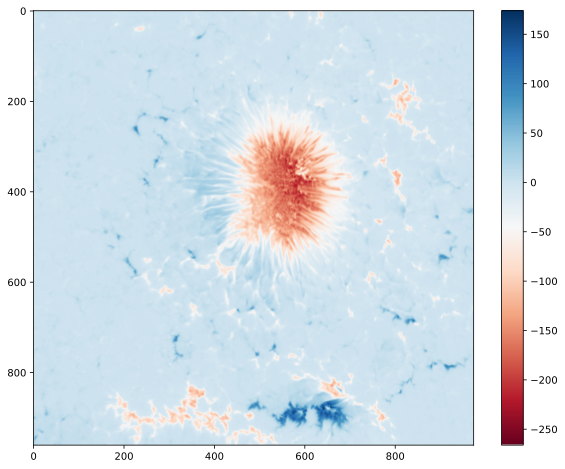

In [18]:
B = np.load("B.npy")

fig, ax = plt.subplots(figsize=(10,8))
p = ax.imshow(B, cmap='RdBu');
fig.colorbar(p, ax = ax)

In [22]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
p = ax.imshow(B, cmap = "RdBu")
q = ax.imshow(data['stokes_v'][4].value, cmap='RdBu')

anim = ArtistAnimation(fig, [[p], [q]], interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())